## <center> **Анализ результатов A/B-тестирования**

Компания планирует запустить новую акцию, чтобы продать как можно больше туров. Команда разработала два варианта посадочной страницы официального сайта компании и провела A/B-тестирование. Собранные в результате проведения эксперимента данные вы можете найти здесь.

Вам предстоит решить настоящую бизнес-задачу: проанализировать эффективность обоих вариантов посадочной страницы сразу по двум критериям: конверсии покупки и среднему чеку. На основе проведенного анализа вам будет необходимо сделать выводы и принять решение: какой из вариантов дизайна более предпочтительный.

Итак, наша фирма предлагает следующие варианты туров и их соответствующие стоимости:
* Таиланд — 100000 рублей;
* Турция — 60000 рублей;
* Мальдивы — 200000 рублей;
* Санкт-Петербург — 10000 рублей;
* Камчатка — 150000 рублей.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
from scipy.stats import t
from scipy.stats import ttest_ind, shapiro, f_oneway, mannwhitneyu
from statsmodels.stats.proportion import proportions_ztest

Прочитаем наши данные и посмотрим на столбцы таблицы:

In [2]:
data = pd.read_csv('/home/tatiana/Internet_shop/ab_data_tourist.csv')
data.head()

,user_id,date,group,purchase,price
0,851104,2021-01-21,A,0,0
1,804228,2021-01-12,A,0,0
2,661590,2021-01-11,B,0,0
3,853541,2021-01-08,B,0,0
4,864975,2021-01-21,A,1,150000


## **Задание 7.1.**

Начнем с исследования структуры наших данных. С помощью метода info() выведите информацию о типах данных и количестве непустых значений. Какой тип данных имеет столбец date?

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   user_id   294478 non-null  int64 
 1   date      294478 non-null  object
 2   group     294478 non-null  object
 3   purchase  294478 non-null  int64 
 4   price     294478 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 11.2+ MB


In [4]:
data.shape[0]

294478

## **Задание 7.2.**

Приведите столбец date к типу данных datetime. Убедитесь в равной длительности проведения тестирования для каждой из группы. Для этого сгруппируйте данные по признаку группы и определите первую и последнюю дату наблюдения для каждой из групп. 

В какой промежуток времени проводился A/B-тест?


In [5]:
data['date'] = pd.to_datetime(data['date'])

In [6]:
data['price_in_millions'] = data['price'] / 1e6

In [7]:
display(data.head())

,user_id,date,group,purchase,price,price_in_millions
0,851104,2021-01-21,A,0,0,0.00
1,804228,2021-01-12,A,0,0,0.00
2,661590,2021-01-11,B,0,0,0.00
3,853541,2021-01-08,B,0,0,0.00
4,864975,2021-01-21,A,1,150000,0.15


In [8]:
data.groupby('group')['date'].agg(['min', 'max'])

,min,max
group,,
A,2021-01-02,2021-01-24
B,2021-01-02,2021-01-24


## **Задание 7.3.**

* Чему равно количество посещений сайта в группах А и B?

* Чему равно суммарное количество покупок в группах А и B?

* Чему равна сумма всех покупок в группах А и B? Ответ приведите в миллионах рублей. Например, 185.52 млн. руб.

In [9]:
print('Количество посещений сайта в группах А и B:')
display(data.groupby('group')['user_id'].agg('count'))
print('\nКоличество покупок в группах А и B:')
display(data.groupby('group')['purchase'].agg('sum'))
print('\nСумма покупок в группах А и B:')
display(data.groupby('group')['price_in_millions'].agg('sum'))

Количество посещений сайта в группах А и B:


group
A    147202
B    147276
Name: user_id, dtype: int64


Количество покупок в группах А и B:


group
A    17723
B    17514
Name: purchase, dtype: int64


Сумма покупок в группах А и B:


group
A    1436.26
B    1554.10
Name: price_in_millions, dtype: float64

## **Задание 7.4.**

Проверьте, есть ли пользователи, которые в процессе A/B-теста попали в обе тестовые группы? Если да, то сколько таких уникальных пользователей, если нет - введите в поле для ответа 0?

**Подсказка:**

*Создайте множество пользователей группы А и множество пользователей группы B. Пересеките два этих множества (операция intersection) и вычислите количество элементов в полученном множестве.*


In [10]:
a_data = data[data['group'] == 'A']
b_data = data[data['group'] == 'B']
user_intersection = set(a_data['user_id']).intersection(set(b_data['user_id']))
print(len(user_intersection))

1895


## **Исключите пользователей, оказавшихся в обеих группах**

Так как мы не можем определить, какая из версий сайта повлияла на принятие решения, исключим этих пользователей. Далее мы будем работать только с очищенными от пересечений данными.

Возможный вариант исключения пользователей:

In [11]:
updated_data = data[data['user_id'].apply(lambda x: x not in user_intersection)]

In [12]:
updated_data.shape[0]

290688

Где user_intersection - множество пересечений пользователей групп А и B.

## **Задание 7.5.**

Для первичного анализа результатов A/B-тестирования нам понадобится таблица следующего вида:

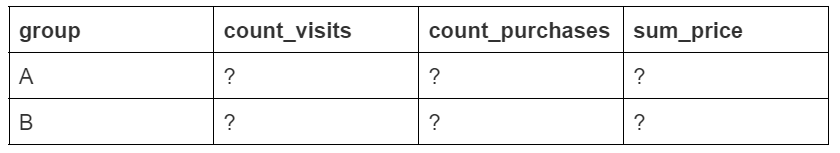
 
 
Для того, чтобы получить такую таблицу, сгруппируйте данные по признаку группы. В каждой группе рассчитайте следующие показатели:
* количество посещений (количество пользователей)
* количество совершенных покупок
* сумма всех покупок в группе

В полученной сгруппированной таблице переименуйте столбцы на **count_visits, count_purchases и sum_price**.

**Подсказка:**

*Для переименования столбцов можно использовать метод rename() с параметром columns, в который передается словарь. Ключи этого словаря - старые имена столбцов, а значения - новые.*

Чему на этот раз равно количество посещений сайта в группах А и B?


In [13]:
grouped = updated_data.groupby('group').agg({'user_id':'count','purchase':'sum','price_in_millions':'sum'}
                                            ).rename(columns = {'user_id':'count_visits','purchase':'count_purchases','price':'sum_price'}
                                            ).reset_index()
display(grouped)

,group,count_visits,count_purchases,price_in_millions
0,A,145307,17487,1417.78
1,B,145381,17290,1533.01


Приведите промежуточные выводы по построенной таблице. Сопоставимо ли количество посещений обоих вариантов посадочной странице, можно ли говорить о сбалансированности выборок?

ВЫВОДЫ: При незначительном преобладании посещений сайта в варианте В посадочной страницы, количество покупок в варианте В сделано меньше. НО: При этом в варианте В суммарная выручка существенно выше, чем в варианте А. 

## **Задание 7.6.**

Добавьте в сгруппированную таблицу столбцы conversion - конверсия покупки (отношение количества покупок к количеству посещений сайта в каждой группе, выраженное в процентах) и mean_check - средний чек (отношение суммы покупок к количеству покупок в каждой группе).

* Чему равна конверсия в группах? Ответ приведите в процентах и округлите до сотых. Например, 75.12 %
* Чему равен средний чек в группах? Ответ приведите в рублях и округлите до целых. Например, 120519 рублей.

In [14]:
grouped['conversion'] = round(grouped['count_purchases'] / grouped['count_visits'] * 100, 2)
display(grouped)

,group,count_visits,count_purchases,price_in_millions,conversion
0,A,145307,17487,1417.78,12.03
1,B,145381,17290,1533.01,11.89


In [15]:
grouped['average_bill'] = round(grouped['price_in_millions'] / grouped['count_purchases'] * 1e6)
display(grouped)

,group,count_visits,count_purchases,price_in_millions,conversion,average_bill
0,A,145307,17487,1417.78,12.03,81076.0
1,B,145381,17290,1533.01,11.89,88665.0


Приведите промежуточные выводы по таблице. По какому(им) показателю(ям) вариант А эффективнее варианта B и наоборот?

ВЫВОДЫ: Конверсия в варианте А незначительно выше, чем в варианте В. Сумма среднего чека в варианте А ниже, чем в варианте В.

## **Задание 7.7.**

Теперь давайте сравним варианты по покупательской способности туров. Для этого постройте сводную таблицу, которая покажет зависимость количества продаж от группы и цены тура. 

In [16]:
pivot = updated_data[updated_data['price'] > 0].pivot_table(
    index='group', 
    columns='price', 
    values='purchase', 
    aggfunc='sum'
)
display(pivot)

price,10000,60000,100000,150000,200000
group,,,,,
A,5182,5271,1832,3478,1724
B,5201,1730,5227,3438,1694


Визуализируйте полученную сводную таблицу с помощью тепловой карты с аннотацией. 
Чему равно количество проданных туров за 60000 рублей в группах?

Text(0.5, 1.0, 'Тепловая карта покупательской способности туров в группах')

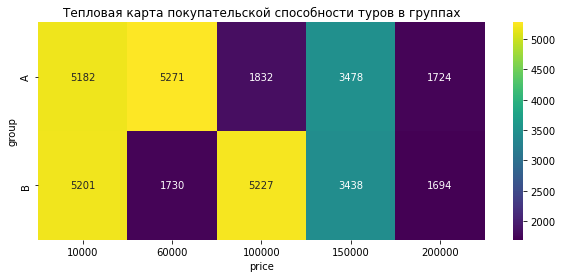

In [17]:
fig = plt.figure(figsize=(10, 4))
ax = sns.heatmap(pivot, fmt='.0f', annot=True, cmap='viridis');
ax.set_title('Тепловая карта покупательской способности туров в группах')

Сделайте выводы по построенной таблице. По каким турам покупательская способность участников группы А выше, чем участников группы B и наоборот?

ВЫВОДЫ: В группе А покупательская активность существенно выше на путевки в Турцию стоимостью 60000 рублей, чем в группе В. В группе В покупательская способность значительно выше на путевки в Тайланд стоимостью 100000, чем в группе А.

## **Задание 7.8.**

Настало время поговорить о стабилизации кумулятивных метрик во времени. Но прежде, чем перейти к кумулятивным метрикам, нам необходимо построить таблицу с ежедневными данными результатов проведения A/B-тестирования.

Сгруппируйте данные по дате и группе тестирования. В каждой группе вычислите количество посещений страницы, количество покупок и сумму покупок. 

Добавьте в таблицу информацию о ежедневной конверсии (ежедневное количество покупок / ежедневное количество посещений) в группе и ежедневном среднем чеке (ежедневная сумма покупок / ежедневное количество покупок)
* Чему равна конверсия 3 января 2021 года? Ответ приведите в процентах и округлите до сотых.

* Чему равен средний чек 3 января 2021 года? Ответ приведите в рублях и округлите до целого.

In [18]:
grouped_daily = updated_data.groupby(['date','group']).agg({'user_id':'count',
                                                            'purchase':'sum',
                                                            'price_in_millions':'sum'}).rename(columns = 
                                                                        {'user_id':'daily_visits',
                                                                        'purchase':'daily_purchase',
                                                                        'price_in_millions':'daily_revenue_mln'}).reset_index()

In [19]:
grouped_daily['daily_conversion'] = round(grouped_daily['daily_purchase'] / grouped_daily['daily_visits'] *100, 2)

In [20]:
grouped_daily['daily_cheque'] = round(grouped_daily['daily_revenue_mln']*1000000 / grouped_daily['daily_purchase']) 

In [21]:
grouped_daily[grouped_daily['date'] == '2021-01-03'][['group','daily_conversion']]

,group,daily_conversion
2,A,11.34
3,B,11.39


## **Задание 7.9.** 

Добавьте в таблицу с ежедневными показателями кумулятивные признаки:
* кумулятивное количество посещений страницы
* кумулятивное количество покупок
* кумулятивную сумму покупок

Не забудьте при расчете кумулятивной суммы сгруппировать данные по группам. 

Вычислите кумулятивную конверсию и кумулятивный средний чек на основе полученных кумулятивных показателей. 

* Какая **кумулятивная** конверсия была в группе B на 20 января? Ответ приведите в процентах, округлив до сотых.
* Какой **кумулятивный** средний чек был в группе А на 12 января 2021 года? Ответ приведите в рублях, округлив до целых.

In [22]:
grouped_daily['cum_visits'] = grouped_daily.groupby('group')['daily_visits'].cumsum()

In [23]:
grouped_daily['cum_purchase'] = grouped_daily.groupby('group')['daily_purchase'].cumsum()

In [24]:
grouped_daily['cum_revenue_mln'] = grouped_daily.groupby('group')['daily_revenue_mln'].cumsum()

In [25]:
grouped_daily['cum_conversion'] = round(grouped_daily['cum_purchase'] / grouped_daily['cum_visits'] * 100, 2)

In [26]:
grouped_daily['cum_cheque'] =round(grouped_daily['cum_revenue_mln'] * 1000000 / grouped_daily['cum_purchase'])

In [27]:
print('Кумулятивная конверсия 20 января 2021 года:')
display(grouped_daily[grouped_daily['date'] == '2021-01-20'][['group', 'cum_conversion']])

Кумулятивная конверсия 20 января 2021 года:


,group,cum_conversion
36,A,11.98
37,B,11.90


In [28]:
print('Кумулятивный средний чек на 12 января 2021 года:')
display(grouped_daily[grouped_daily['date'] == '2021-01-12'][['group', 'cum_cheque']])

Кумулятивный средний чек на 12 января 2021 года:


,group,cum_cheque
20,A,81492.0
21,B,88352.0


Постройте кумулятивные графики конверсии и среднего чека в каждой группе по дням. Сделайте выводы. Можно ли назвать A/B-тест завершенным - стабилизировались ли значения метрик во времени? Как соотносятся кумулятивные показатели в каждой группе?

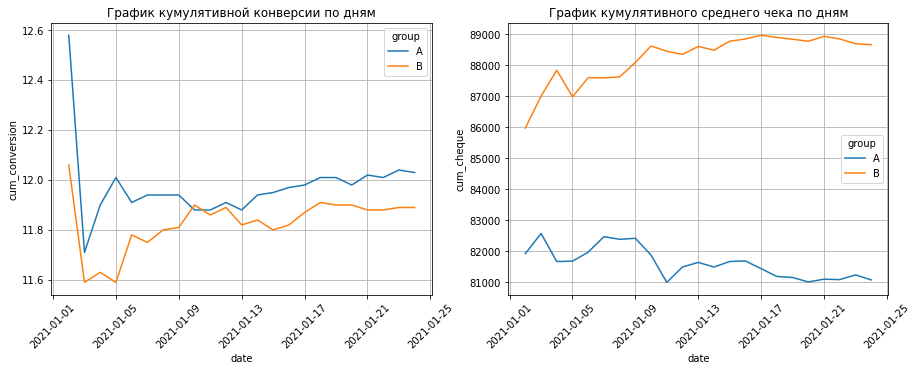

In [29]:
fig, axes= plt.subplots(1, 2, figsize=(15, 5))
sns.lineplot(x='date', y='cum_conversion', data=grouped_daily, hue='group', ax=axes[0])
sns.lineplot(x='date', y='cum_cheque', data=grouped_daily, hue='group', ax=axes[1])
axes[0].set_title('График кумулятивной конверсии по дням')
axes[1].set_title('График кумулятивного среднего чека по дням')
axes[0].xaxis.set_tick_params(rotation = 45)
axes[1].xaxis.set_tick_params(rotation = 45)
axes[0].grid(True);
axes[1].grid(True);

ВЫВОДЫ: На графиках видно, что начиная с 2021-01-17 значения кумулятивной конверсии и кумулятивного среднего чека стабилизировались во времени. Конверсия в группе А стабильно немного выше конверсии в группе В. Кумулятивный средний чек в группе А выше, чем в группе В. 
Длительность эксперимента была достаточной для того, чтобы судить о статистической значимости разности между показателями конверсии и среднего чека в группах. А/В тест можно считать завершенным.

## **Задание 7.10.**

Настало время переходить к проверке статистической значимости разницы между метриками в группах. Начнем с конверсии.

Какой тест вы примените для проверки гипотезы о равенстве конверсий в группах?

Проведите тестирование при следующих нулевой и альтернативной гипотезе:
* $H_0$: Конверсии в группах А и B равны; 
* $H_1$: Конверсия в группе А больше чем конверсия в группе B;

Вычислите p-value вашего теста для конверсий в группах А и B. Сравните полученное значение p-value с уровнем значимости $\alpha$=0.05. 

In [30]:
display(updated_data.head(2))

,user_id,date,group,purchase,price,price_in_millions
0,851104,2021-01-21,A,0,0,0.0
1,804228,2021-01-12,A,0,0,0.0


In [31]:
converted= updated_data.groupby('group')['purchase'].agg(
    ['sum', 'count','mean']
)
display(converted)

,sum,count,mean
group,,,
A,17487,145307,0.120345
B,17290,145381,0.118929


In [32]:
# нулевая и альтернативная гипотезы
H0 = 'Конверсии в группах А и B равны'
H1 = 'Конверсия в группе А выше, чем конверсия в группе B'
alpha = 0.05 # уровень значимости
# вычисляем значение p-value для z-теста для пропорций
_, p_value = proportions_ztest(
    count=converted['sum'], #число "успехов"
    nobs=converted['count'], #общее число наблюдений
    alternative='larger',
)
# выводим результат на экран
print('p-value: ', round(p_value, 2))
# сравниваем полученное p-value с уровнем значимости
if (p_value < alpha): 
    print("Отвергаем нулевую гипотезу. {}".format(H0))
    print("Альтернативная гипотеза. H1: {}".format(H1))
else:
    print("Принимаем нулевую гипотезу. {}".format(H0))

p-value:  0.12
Принимаем нулевую гипотезу. Конверсии в группах А и B равны


Приведите свои выводы по результатам проведенного статистического теста. Есть ли статистическая разница между конверсиями в группах А и B?

ВЫВОД: При заданном уровне значимости $\alpha$=0.05 конверсии в группах А и В равны. Статистической разницы между конверсиями в группах А и В нет.

## **Задание 7.11.**
Убедитесь в своих рассуждениях, построив 95%-ый доверительный интервал для конверсий и разницы между ними. Используйте $z_{крит}$ в своих расчетах

Укажите нижнюю и верхнюю границы доверительных интервалов. Границы приведите в процентах и округлите до 2 знака после запятой. Например: нижняя граница 89.24%, верхняя граница 91.25%.

In [33]:
def conversion_conf_interval(n, x_p, gamma=0.95): # n - размер выборки, x_p - выборочная пропорция, 
                                                  # gamma - надежность интервала
    alpha = 1 - gamma # уровень значимости
    z_crit = -norm.ppf(alpha/2) # z критическое
    eps = z_crit * (x_p * (1 - x_p) / n) ** 0.5 #погрешность
    lower_bound = x_p - eps # левая (нижняя) граница
    upper_bound = x_p + eps # правая (верхняя) граница
    # возвращаем кортеж из округленных границ интервала
    return round(lower_bound * 100, 2), round(upper_bound * 100, 2)

a_data = updated_data[updated_data['group'] == 'A']
b_data = updated_data[updated_data['group'] == 'B']
conf_interval_a = conversion_conf_interval(
a_data['user_id'].count(), # размер выборки
a_data['purchase'].mean() # выборочная пропорция
)
conf_interval_b = conversion_conf_interval(
b_data['user_id'].count(), # размер выборки
b_data['purchase'].mean() # выборочная пропорция
)
print('Доверительный интервал для конверсии группы А: {}'.format(conf_interval_a))
print('Доверительный интервал для конверсии группы B: {}'.format(conf_interval_b))

Доверительный интервал для конверсии группы А: (11.87, 12.2)
Доверительный интервал для конверсии группы B: (11.73, 12.06)


In [34]:
def diff_conversion_conf_interval(n, xp, gamma=0.95):
    alpha = 1 - gamma # уровень значимости
    diff = xp[1] - xp[0] # выборочная разница конверсий групп B и A
    t_crit = -norm.ppf(alpha/2) #z критическое
    eps = t_crit * (xp[0] * (1 - xp[0])/n[0] + xp[1] * (1 - xp[1])/n[1]) ** 0.5 # погрешность
    lower_bound = diff - eps # левая (нижняя) граница
    upper_bound = diff + eps # правая (верхняя) граница
    # возвращаем кортеж из округленных границ интервала
    return round(lower_bound *100, 2), round(upper_bound * 100, 2)

# размеры выборок групп А и B
n = [a_data['user_id'].count(), b_data['user_id'].count()]
# выборочная пропорция групп A и B
xp = [a_data['purchase'].mean(), b_data['purchase'].mean()]

# строим доверительный интервал для разности
diff_inverval = diff_conversion_conf_interval(n, xp)
print('Доверительный интервал для разности конверсий: {}'.format(diff_inverval)) 

Доверительный интервал для разности конверсий: (-0.38, 0.09)


Проинтерпретируйте построенные доверительные интервалы для конверсий в группах. Есть ли перекрытие между доверительными интервалами для групп? Есть ли статистическая разница между конверсиями в группах А и B?

ВЫВОДЫ: Существует перекрытие между доверительными интервалами, построенными для конверсий в группах А и В. Статистической разницы между конверсиями в группах А и В не существует. Они являются равнозначными по данной метрике.

## **Задание 7.12.**

Ранее мы построили таблицу с ежедневными показателями. Теперь она нам снова понадобится, так как нас интересует ежедневный средний чек.

Проверьте гипотезу о нормальности распределения ежедневного среднего чека в каждой из групп тестирования. 

* Какой тест вы примените  для проверки гипотезы о нормальности распределения ежедневного среднего чека?
* Как будут звучать нулевая и альтернативная гипотезы?
* Каковы результаты статистического теста с уровнем значимости $\alpha$ =0.05?

In [35]:
display(grouped_daily.head(2))

,date,group,daily_visits,daily_purchase,daily_revenue_mln,daily_conversion,daily_cheque,cum_visits,cum_purchase,cum_revenue_mln,cum_conversion,cum_cheque
0,2021-01-02,A,2854,359,29.41,12.58,81922.0,2854,359,29.41,12.58,81922.0
1,2021-01-02,B,2861,345,29.66,12.06,85971.0,2861,345,29.66,12.06,85971.0


In [36]:
# нулевая и альтернативная гипотезы
H0 = 'Распределения в обеих группах нормальные'
H1 = 'Распределение в одной или обеих группах отлично от нормального'
alpha = 0.05 # уровень значимости
 
daily_data_a = grouped_daily[grouped_daily['group'] == 'A']
daily_data_b = grouped_daily[grouped_daily['group'] == 'B']
 
# вычисляем результат теста Шапиро-Уилка для выборок
shapiro_result_a = shapiro(daily_data_a['daily_cheque'])
shapiro_result_b = shapiro(daily_data_b['daily_cheque'])
print('p-value группы А', round(shapiro_result_a.pvalue, 2))
print('p-value группы B', round(shapiro_result_b.pvalue, 2))
# сравниваем полученное p-value с уровнем значимости
if shapiro_result_a.pvalue < alpha or shapiro_result_b.pvalue < alpha:
    print("Отвергаем нулевую гипотезу. {}".format(H0))
    print("Альтернативная гипотеза. H1: {}".format(H1))
else:
    print("Принимаем нулевую гипотезу. {}".format(H0))

p-value группы А 0.25
p-value группы B 0.09
Принимаем нулевую гипотезу. Распределения в обеих группах нормальные


## **Задание 7.13.**
Настало время сравнить варианты дизайна страницы по метрике среднего чека. 

Какой тест вы примените для проверки гипотезы о равенстве средних чеков по дням в группах?

Проведите тестирование при следующих нулевой и альтернативной гипотезе:
* $H_0$: Ежедневные средние чеки в группах А и B равны; 
* $H_1$: Ежедневный средний чек в группе А меньше чем в группе B;

Вычислите p-value вашего теста для ежедневного среднего чека в группах А и B. Сравните полученное значение p-value с уровнем значимости $\alpha$ =0.05. 

In [37]:
# нулевая и альтернативная гипотезы
H0 = 'Ежедневные средние чеки в группах А и B равны'
H1 = 'Ежедневный средний чек в группе А меньше чем в группе B'
alpha = 0.05 #уровень значимости
 
daily_data_a = grouped_daily[grouped_daily['group'] == 'A']
daily_data_b = grouped_daily[grouped_daily['group'] == 'B']
 
#вычисляем результат T-теста для выборок
results = ttest_ind(
    daily_data_a['daily_cheque'],
    daily_data_b['daily_cheque'],
    alternative='less'
)
print('p-value:', round(results.pvalue, 2))
 
if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу. {}".format(H0))
    print("Альтернативная гипотеза. H1: {}".format(H1))
else:
    print("Принимаем нулевую гипотезу. {}".format(H0))

p-value: 0.0
Отвергаем нулевую гипотезу. Ежедневные средние чеки в группах А и B равны
Альтернативная гипотеза. H1: Ежедневный средний чек в группе А меньше чем в группе B


 Приведите свои выводы по проведенному статистическому тесту. Есть ли статистическая разница между ежедневными средними чеками в группах А и B?

ВЫВОД: Т-тест показал, что существует статистическая разница между средними чеками в группах А и В. Ежедневный средний чек в группе А меньше, чем в группе В.

## **Задание 7.14.**

Постройте 95%-ый доверительный интервал для среднего чека в каждой группе. Так как выборка средних чеков небольшая, используйте  $t_{крит}$ в своих расчетах.

Укажите нижнюю границу доверительного интервала для истинного среднего чека каждой из групп. Ответ приведите в процентах и округлите до целого.

In [38]:
def mean_check_conf_interval(n, x_mean, x_std, gamma=0.95):
    k = n - 1 #число степеней свободы
    alpha = 1 - gamma # уровень значимости
    t_crit = -t.ppf(alpha/2, k) # t критическое
    eps = t_crit * x_std / n**0.5 #погрешность
    lower_bound = x_mean - eps # левая (нижняя) граница
    upper_bound = x_mean + eps # правая (верхняя) граница
    # возвращаем кортеж из округленных границ интервала
    return round(lower_bound), round(upper_bound)
 
a_daily_data = grouped_daily[grouped_daily['group'] == 'A']
b_daily_data = grouped_daily[grouped_daily['group'] == 'B']
 
params_a = {
    'n': a_daily_data['daily_visits'].count(), # размер выборки
    'x_mean': a_daily_data['daily_cheque'].mean(), # выборочное средние
    'x_std': a_daily_data['daily_cheque'].std() # выборочное стандартное отклонения
}
params_b = {
    'n': b_daily_data['daily_visits'].count(),# размер выборки
    'x_mean': b_daily_data['daily_cheque'].mean(), # выборочное средние
    'x_std': b_daily_data['daily_cheque'].std() # выборочное стандартное отклонения
}
 
print('Доверительный интервал для среднего чека группы А: {}'.format(mean_check_conf_interval(**params_a))) 
print('Доверительный интервал для среднего чека группы B: {}'.format(mean_check_conf_interval(**params_b)))

Доверительный интервал для среднего чека группы А: (79630, 82308)
Доверительный интервал для среднего чека группы B: (87626, 89526)


Проинтерпретируйте построенные доверительные интервалы для ежедневных средних чеков в группах. Есть ли между ними пересечения?

ВЫВОДЫ: Доверительные интервалы средних чеков в группах А и В не пересекаются. Средний чек в группе В в доверительном 95% интервале выше среднего чека в группе А.

## **Сделайте общий вывод по результатам A/B-теста**

Какой варианта дизайна посадочной страницы является более эффективным в комплексе по метрикам конверсии и среднего чека и почему? 


На основании проведенного анализа удалось установить, что: 

1. НЕТ СТАТИСТИЧЕСКОЙ РАЗНИЦЫ МЕЖДУ КОНВЕРСИЯМИ В ГРУППАХ ПОЛЬЗОВАТЕЛЕ А И В.

2. ОБНАРУЖЕНА СУЩЕСТВЕННАЯ СТАТИСТИЧЕСКАЯ РАЗНИЦА МЕЖДУ СРЕДНИМ ЧЕКОМ В ГРУППАХ. Срдений чек в ГРУППЕ В (страница с новым дизайном) ВЫШЕ чека в ГРУППЕ А (страница со старым дизайном).

3. Пользователи ГРУППЫ А покупали существенно БОЛЬШЕ ПУТЕВОК В ТУРЦИЮ СТОИМОСТЬЮ 60000 РУБЛЕЙ чем пользователи группы В. 

4. Пользователи ГРУППЫ В покупали существенно БОЛЬШЕ ПУТЕВОК В ТАЙЛАНД СТОИМОСТЬЮ 100000 РУБЛЕЙ чем пользователи группы А.

ВЫВОДЫ:

1. АКЦИЯ, добавленная на посадочную страницу с новым дизайном, СТИМУЛИРУЕТ более состоятельных клиентов ПОКУПАТЬ БОЛЕЕ ДОРОГИЕ ТУРЫ в Тайланд. 

2. НОВАЯ СТРАНИЦА выглядит МЕНЕЕ ПРИВЛЕКАТЕЛЬНОЙ по сравнению со старой страницей для покупателей, рассчитывающих приобрести более БЮДЖЕТНЫЙ ТУР.

3. В комплексе по метрикам конверсии и среднего чека вариант новой страницы является более эффективным, поскольку при равных значениях конверсии в группах А и В, средний чек в группе В существенно выше.

ПРЕДЛОЖЕНИЯ: 
1. Перейти к новому варианту посадочной страницы, как к более эффективному.

2. Доработать новую посадочную страницу таким образом, чтобы реклама новой акции, по-прежнему акцентируя внимание клиентов на новые туры в Тайланд, не отпугивала клиентов готовых приобрести бюджетные туры в Турцию. 
